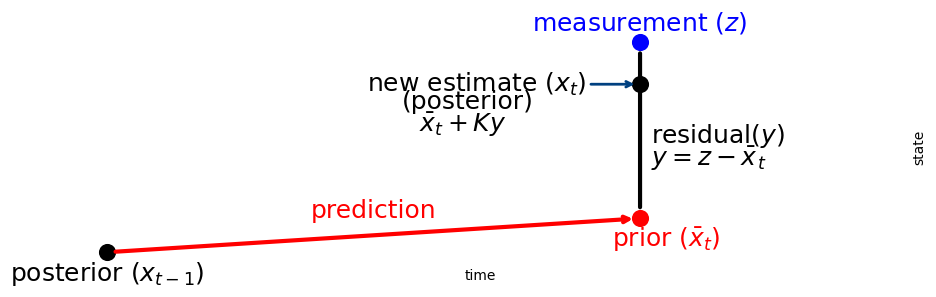

In [1]:
%matplotlib inline

import book_format
book_format.set_style()

import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

In [1]:


import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)



In [5]:
from scipy.linalg import solve
from filterpy.kalman import predict

dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


In [6]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


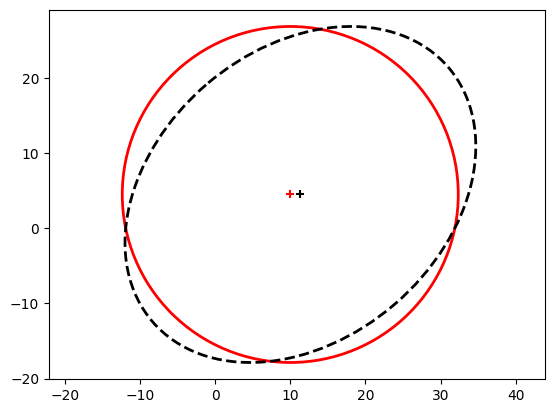

In [7]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

In [8]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


In [9]:
B = 0.  # my dog doesn't listen to me!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [12.7  4.5]
P = [[680.5875 301.175 ]
 [301.175  502.35  ]]


In [10]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]

array([ True,  True])

In [11]:
H = np.array([[1., 0.]])

In [12]:
R = np.array([[5.]])

In [13]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.08532828 -0.63974876]


In [14]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


In [15]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [16]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

In [17]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f116c2c1000>

In [18]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

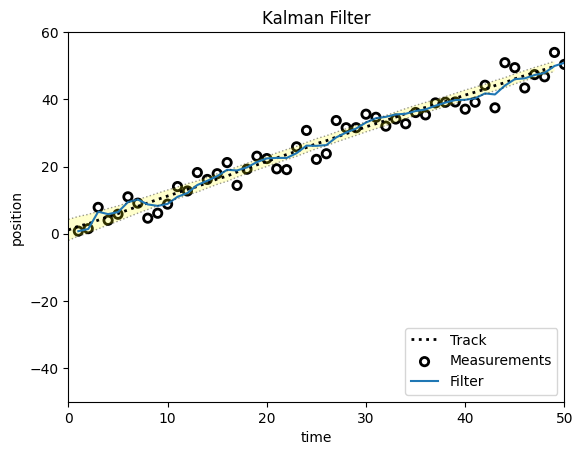

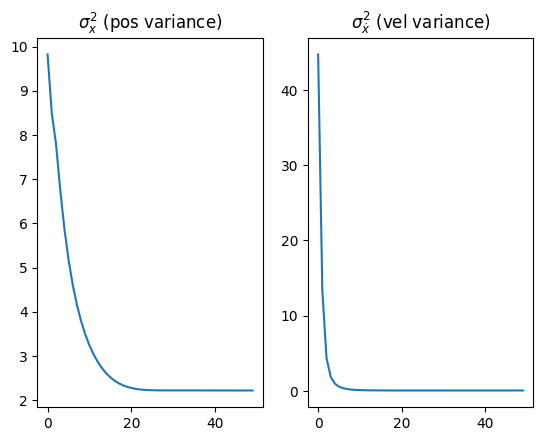

In [19]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

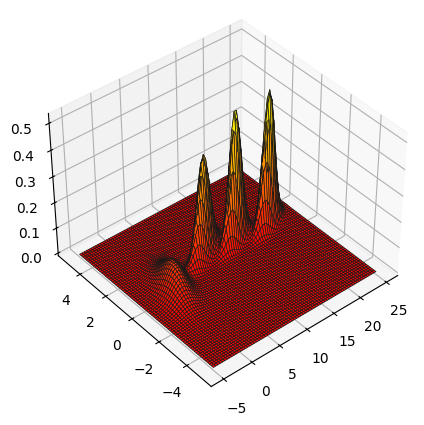

In [20]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

In [21]:
from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

s.x

[array([0.53063885, 0.3041721 ]),
 array([1.55544446, 0.76347564]),
 array([2.78435899, 1.03588193]),
 array([3.94381847, 1.10519678]),
 array([5.01546601, 1.08642624])]

In [22]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

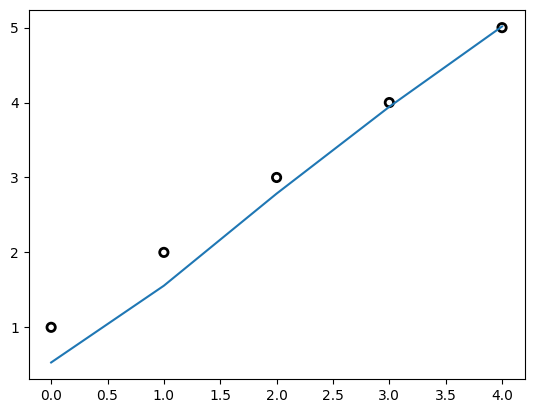

In [24]:
import matplotlib.pyplot as plt
import kf_book.book_plots as book_plots

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

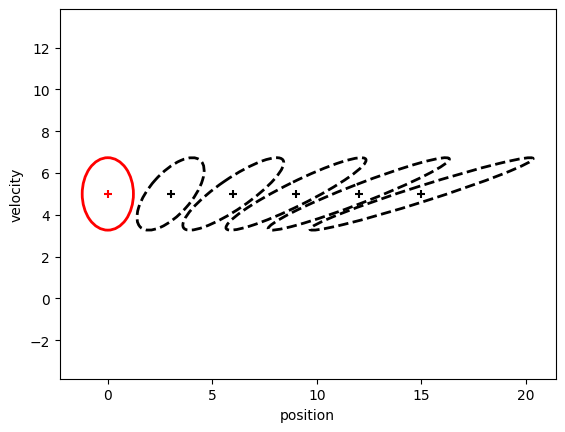

In [25]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

In [26]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.show()
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

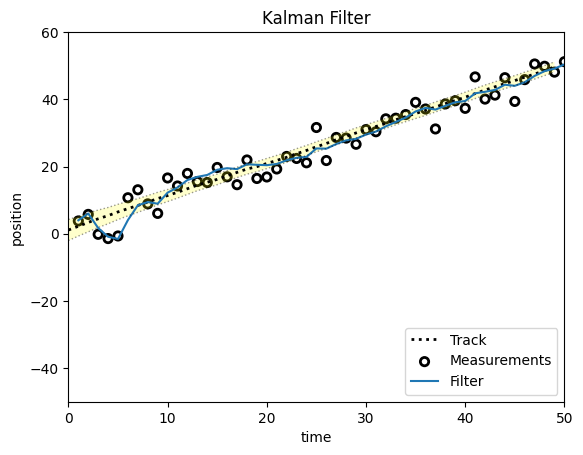

In [27]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

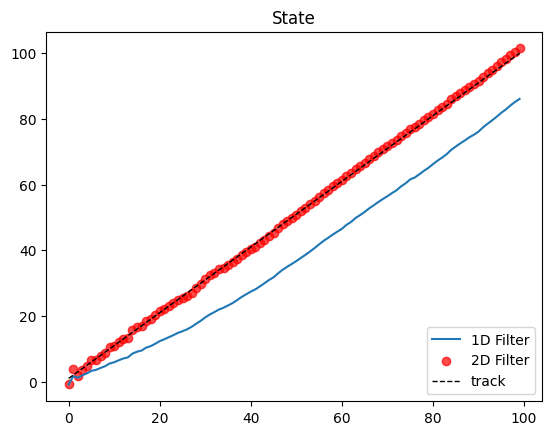

In [28]:
from math import sqrt
from numpy.random import randn

def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.x = np.array([[x0]])
    f.P *= P
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label='1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c='r', alpha=0.7, label='2D Filter')
    plt.plot(xs, ls='--', color='k', lw=1, label='track')
    plt.title('State')
    plt.legend(loc=4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u=None):
    # storage for filter output
    xs, xs1, xs2 = [], [], []

    # 1d KalmanFilter
    f1D = univariate_filter(x0, P, R, Q)

    #2D Kalman filter
    f2D = pos_vel_filter(x=(x0, vel), P=P, R=R, Q=0)
    if np.isscalar(u):
        u = [u]
    pos = 0 # true position
    for i in range(100):
        pos += vel
        xs.append(pos)

        # control input u - discussed below
        f1D.predict(u=u)
        f2D.predict()
        
        z = pos + randn()*sqrt(R) # measurement
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)

compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1.) 

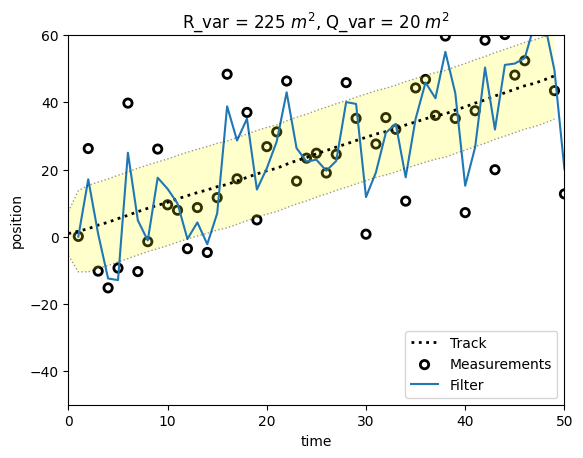

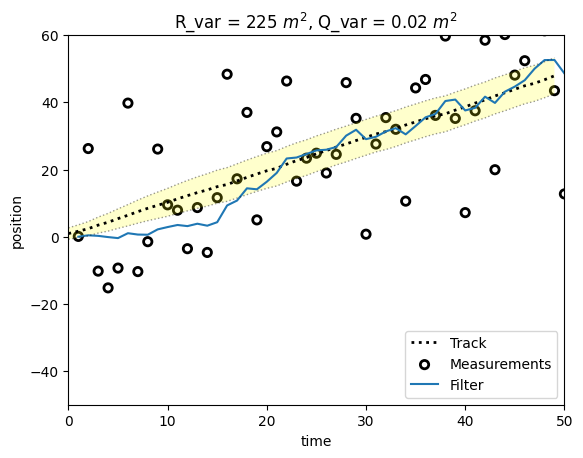

In [29]:
from numpy.random import seed
seed(2)
trk, zs = compute_dog_data(z_var=225, process_var=.02, count=50)

run(track=trk, zs=zs, R=225, Q=200, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 20 $m^2$')
run(track=trk, zs=zs, R=225, Q=.02, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 0.02 $m^2$');

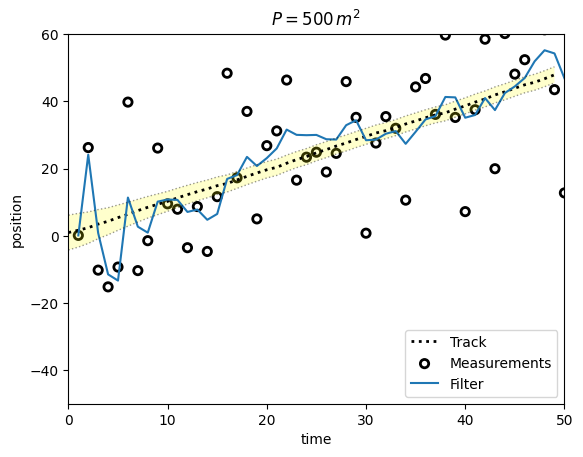

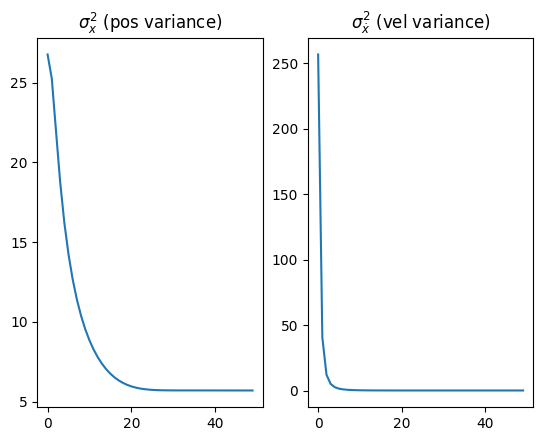

In [30]:
import kf_book.mkf_internal as mkf_internal

var = 27.5
data = mkf_internal.zs_var_275()
run(track=trk, zs=zs, R=var, Q=.02, P=500., plot_P=True, 
    title='$P=500\, m^2$');

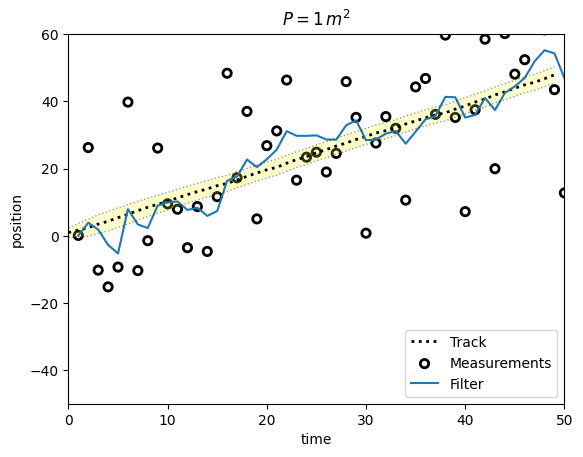

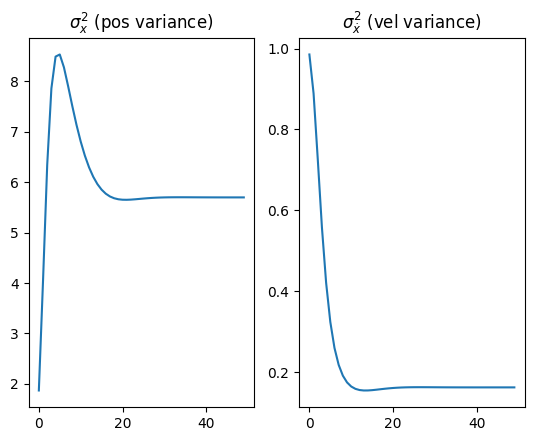

In [31]:
run(track=trk, zs=zs, R=var, Q=.02, P=1., plot_P=True, 
    title='$P=1\, m^2$');

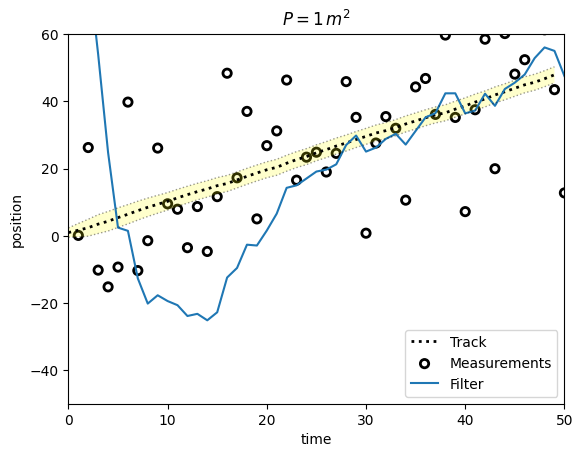

In [32]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=1., x0=x,
    plot_P=False, title='$P=1\, m^2$');

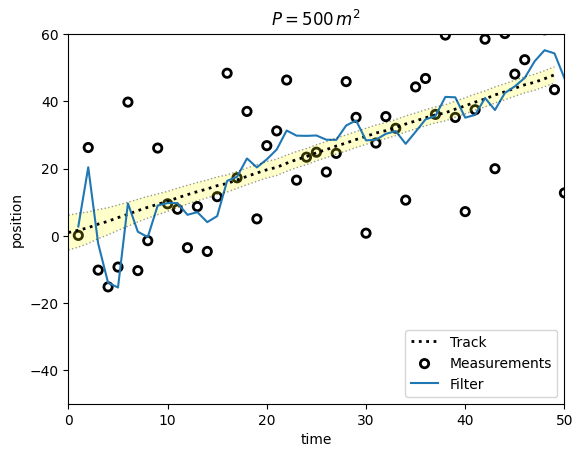

In [33]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=500., x0=x,
   plot_P=False, title='$P=500\, m^2$');

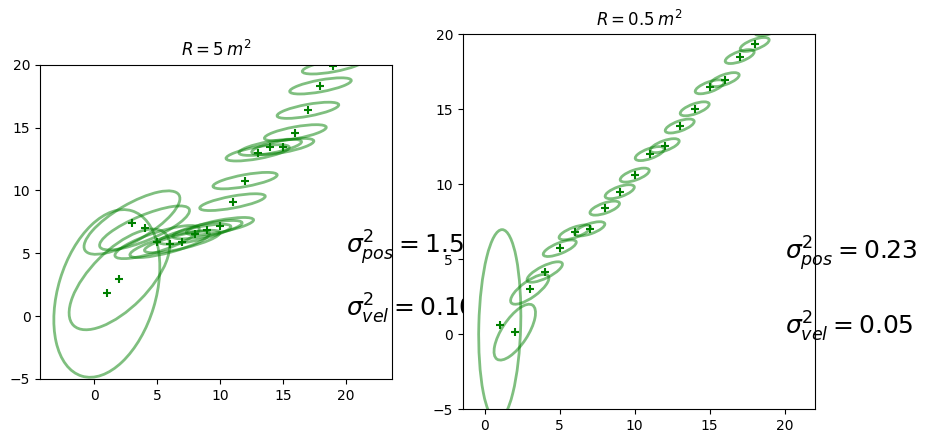

In [34]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(10,6))
plt.subplot(121)
plot_covariances(R=5, Q=.02, count=20, title='$R = 5\, m^2$')
plt.subplot(122)
plot_covariances(R=.5, Q=.02, count=20, title='$R = 0.5\, m^2$')

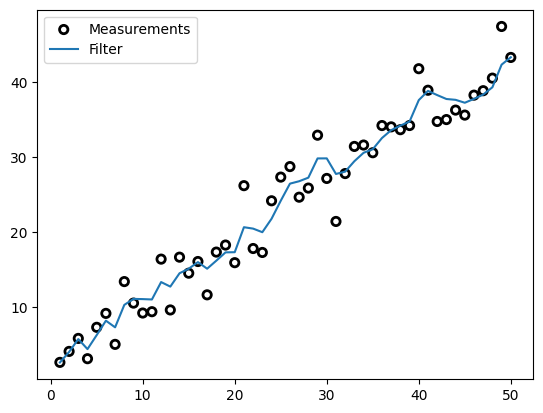

In [35]:
count = 50
track, zs = compute_dog_data(10, .2, count)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

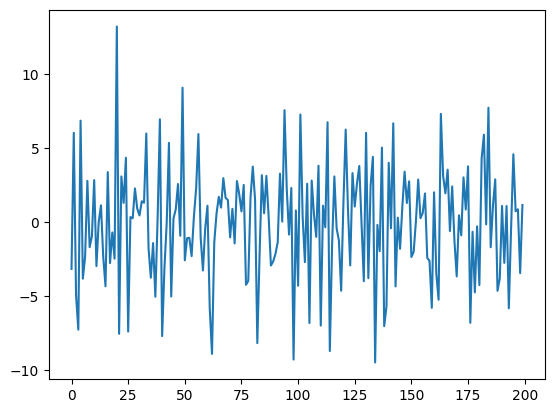

In [36]:
track, zs = compute_dog_data(10, .2, 200)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
s = Saver(f)
xs, _, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y);

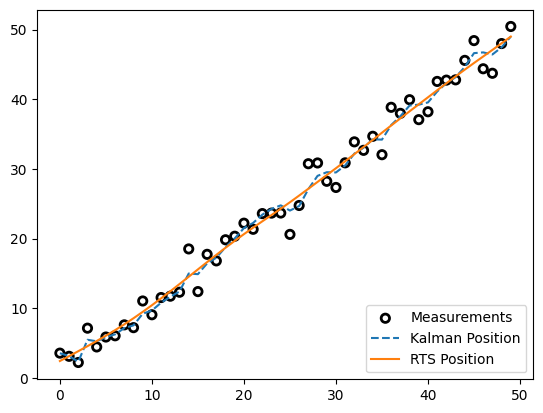

In [37]:
from numpy.random import seed
count = 50
seed(8923)

P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
track, zs = compute_dog_data(3., .02, count)
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:, 0], ls='--', label='Kalman Position')
plt.plot(Ms[:, 0], label='RTS Position')
plt.legend(loc=4);